# Compare Task Overhead
Compare the difference sources of task overhead for our runs.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import json

Configuration

In [2]:
runs = {
    'Baseline': Path('./prod-runs/baseline_retrain-20/'),
    'Parsl+Redis': Path('./prod-runs/parsl_retrain-20/'),
    'FuncX+Globus': Path('./prod-runs/funcx_retrain-20/'),
}

## Load in Overhead Dataframes
We stored the results of each dataframe

In [3]:
results = {}
for k, path in runs.items():
    # Get the duplicates
    with open(path / 'duplicates.json') as fp:
        dupes = json.load(fp)
    
    # Compute the mean RMSD for each run
    results[k] = pd.concat([
        pd.read_csv(Path(p) / 'processed-results' / 'overheads.csv') for p in dupes
    ])

## Get the Distribution of Times
Make sure there are not significant outliers

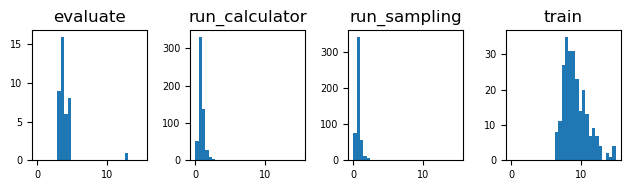

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(6.5, 2.))

for (gid, group), ax in zip(results['FuncX+Globus'].groupby('method'), axs):
    ax.hist(group['overhead_total'], bins=np.linspace(0, 15, 32))
    ax.set_title(gid)
    
fig.tight_layout()

## Make a Box Plot
Plot the overhead for each type on task for each example

Baseline [0.9624548889696598, 0.17002974567003581, 0.785573442291934, 0.0243048535194247]
Parsl+Redis [0.4947670486634289, 0.1165553727853495, 0.1754860191461998, 0.17429439171046252]
Parsl+Redis [0.385326097, 0.063145353, 0.136364732, 0.13413358649999998]
FuncX+Globus [8.913515586062253, 3.7338205298783995, 0.7823538713576004, 0.8443574505190236]
FuncX+Globus [3.6226308525, 2.377466567, 0.106360541, 0.107892252]


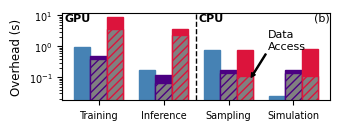

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 1.4))

width = 0.25
colors = {
    'Baseline': 'steelblue',
    'FuncX+Globus': 'crimson',
    'Parsl+Redis': 'indigo'
}

methods = ['train', 'evaluate', 'run_sampling', 'run_calculator']
for i, (name, overheads) in enumerate(results.items()):
    # Make a bar plot where we show the 
    data = [overheads.query(f'method=="{method}"')['overhead_total'].median() for method in methods]
    pos = np.arange(4) - len(results) * width / 2 + i * width
    ax.bar(pos, data, color=colors[name], edgecolor=colors[name], width=width, align='edge', label=name)
    print(name, data)
    
    if "+" in name:
        overheads['time_resolving'] = overheads['time_input_resolution'] + overheads['time_output_resolution']
        data = [overheads.query(f'method=="{method}"')['time_resolving'].median()
                for method in methods]
        ax.bar(pos, data, color='gray', edgecolor=colors[name], width=width, align='edge', hatch='////')
        print(name, data)

# Make a verical bar denoting which are remote and which are local
ax.set_yscale('log')
ax.set_ylabel('Overhead (s)')
ax.set_ylim(ax.get_ylim())
ax.plot([1.5]*2, ax.get_ylim(), 'k--', lw=1)

# Annotate what the candy-cane parts mean
ax.annotate('Data\nAccess', xy=(2.35, 0.1), xytext=(2.6, 0.8), ha='left', fontsize=8,
            arrowprops={"width": 0.75, "color": "k", "headwidth": 3, "headlength": 3})

bbox_kwargs = None # {'facecolor': 'w', 'alpha': 0.5, "boxstyle": "round, pad=0.4"}
ax.text(0.01, 0.9, 'GPU', ha='left', transform=ax.transAxes, fontweight='bold', fontsize=8, bbox=bbox_kwargs)
ax.text(0.51, 0.9, 'CPU', ha='left', transform=ax.transAxes, fontsize=8, fontweight='bold', bbox=bbox_kwargs)
ax.text(1, 1, '(b)', ha='right', va='top', transform=ax.transAxes, fontsize=8)


#fig.legend(ncol=3, fontsize=8, loc='upper center')
    
ax.set_xticks([])
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['Training', 'Inference', 'Sampling', 'Simulation'])

fig.tight_layout()
fig.savefig('figures/overhead-comparison.png', dpi=320)
fig.savefig('figures/overhead-comparison.pdf')

Display the breakdown of latency for the remote tasks of Globus

In [6]:
results['FuncX+Globus'].query('method=="evaluate"').describe()

,time_created,time_result_sent,time_running,time_input_resolution,time_output_resolution,overhead_total,overhead_sending,overhead_serialization,overhead_reporting,overhead_to_result_queue,time_resolving
count,4.000000e+01,4.000000e+01,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,1.678592e+09,1.678592e+09,2.687452,2.443332,0.239286,4.019033,2.997347,0.430309,1.020720,1.020720,2.682618
std,1.229682e+04,1.229677e+04,0.619880,0.607466,1.358134,1.486335,0.378894,0.035903,1.351476,1.351476,1.636564
min,1.678576e+09,1.678576e+09,1.365019,1.128584,0.000000,3.205714,2.434747,0.380437,0.488487,0.488487,1.128584
25%,1.678582e+09,1.678582e+09,2.412569,2.190283,0.000000,3.586458,2.668299,0.402272,0.627394,0.627394,2.212343
50%,1.678588e+09,1.678588e+09,2.607254,2.341570,0.000000,3.733821,2.932534,0.422437,0.818635,0.818635,2.377467
75%,1.678604e+09,1.678604e+09,3.301298,3.070993,0.000000,4.156230,3.384190,0.450561,0.986831,0.986831,3.193732
max,1.678608e+09,1.678608e+09,3.715460,3.477277,8.601400,12.832221,3.569638,0.516049,9.261721,9.261721,12.078677


In [7]:
results['FuncX+Globus'].query('method=="train"').describe()

,time_created,time_result_sent,time_running,time_input_resolution,time_output_resolution,overhead_total,overhead_sending,overhead_serialization,overhead_reporting,overhead_to_result_queue,time_resolving
count,2.560000e+02,2.560000e+02,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,1.678589e+09,1.678589e+09,263.304422,3.103335,0.752670,9.481346,3.620695,0.664587,5.859544,5.859544,3.856005
std,1.115657e+04,1.115872e+04,8.950871,0.836415,1.136816,2.116781,0.782583,0.189378,1.965845,1.965845,1.396617
min,1.678571e+09,1.678571e+09,245.405827,0.289108,0.195533,6.435510,2.586933,0.465983,3.336895,3.336895,0.637593
25%,1.678580e+09,1.678580e+09,257.058757,2.622787,0.280051,8.027589,3.144815,0.510416,4.514155,4.514155,3.046264
50%,1.678588e+09,1.678589e+09,263.247605,3.096139,0.311476,8.913516,3.576888,0.550664,5.429843,5.429843,3.622631
75%,1.678597e+09,1.678597e+09,270.695878,3.443144,0.349681,10.434206,3.811984,0.822804,6.512538,6.512538,4.000003
max,1.678609e+09,1.678609e+09,280.077214,5.995617,11.403242,17.137401,6.982433,1.476612,14.011022,14.011022,14.237372
